In [16]:
import pandas as pd
import numpy as np
import os
import math
from sklearn import metrics
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost.sklearn import XGBClassifier
%matplotlib inline

## Disclaimer:
This model is provided for demonstration purposes only. No liability shall attach to Richard James Dunn in respect of the use of this model or any data or decisions arising therefrom.

In [2]:
os.getcwd()
os.chdir('C:/Users/Richard/OneDrive/My Documents/Job/2019 job desc/liberis data science case study')

In [3]:
df = pd.read_csv('partner_data.csv', encoding = "ISO-8859-1", parse_dates=True)

In [4]:
df.columns

Index(['customer#', 'date_funded', '£_sales_month_1', '£_sales_month_2',
       '£_sales_month_3', '£_sales_month_4', '£_sales_month_5',
       '£_sales_month_6', '£_sales_month_7', '£_sales_month_8',
       '£_sales_month_9', '£_sales_month_10', '£_sales_month_11',
       '£_sales_month_12', '£_sales_month_13', '£_sales_month_14',
       '£_sales_month_15', '£_sales_month_16', '£_sales_month_17',
       '£_sales_month_18', '£_sales_month_19', '£_sales_month_20',
       '£_sales_month_21', '£_sales_month_22', '£_sales_month_23',
       '£_sales_month_24', '#_sales_month_1', '#_sales_month_2',
       '#_sales_month_3', '#_sales_month_4', '#_sales_month_5',
       '#_sales_month_6', '#_sales_month_7', '#_sales_month_8',
       '#_sales_month_9', '#_sales_month_10', '#_sales_month_11',
       '#_sales_month_12', '#_sales_month_13', '#_sales_month_14',
       '#_sales_month_15', '#_sales_month_16', '#_sales_month_17',
       '#_sales_month_18', '#_sales_month_19', '#_sales_month_20',
     

Format dates

In [5]:
df.date_funded = pd.to_datetime(df.date_funded, format = '%d/%m/%Y')
df.date_joined_partner = pd.to_datetime(df.date_joined_partner, format = '%d/%m/%Y')

Check if normalised data set 

In [6]:
df.duplicated('customer#').value_counts()

False    5000
dtype: int64

Cleanse all values > £1m 

In [7]:
for x in np.arange(1, 25, 1):
    df['£_sales_month_' + str(x)] = np.where(df['£_sales_month_' + str(x)]  > 1000000, np.nan, df['£_sales_month_' + str(x)] )

Initially check if £ Sales distribution is different for defaulters

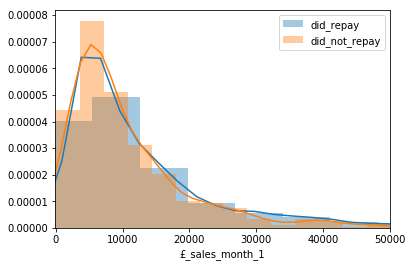

In [8]:
defaults = [0, 1]

for x in defaults:
    subset = df[df['did_not_repay'] == x]
    sns.distplot(subset[~subset['£_sales_month_1'].isnull()]['£_sales_month_1'].astype(int))
    plt.xlim(-100,50000)
    plt.legend(labels=['did_repay','did_not_repay'])

Sales for defaulters vs non defaulters

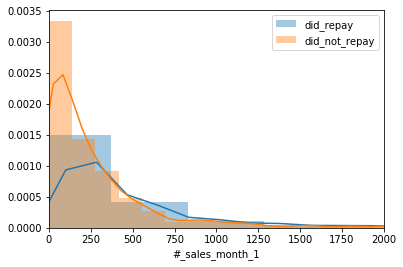

In [9]:
for x in defaults:
    subset = df[df['did_not_repay'] == x]
    sns.distplot(subset[~subset['#_sales_month_1'].isnull()]['#_sales_month_1'].astype(int))
    plt.xlim(0,2000)
    plt.legend(labels=['did_repay','did_not_repay'])

In [10]:
df.groupby('did_not_repay')['#_sales_month_1'].mean()

did_not_repay
0    427.898714
1    357.144144
Name: #_sales_month_1, dtype: float64

Create average sale amount columns £. Could be a good proxy for the sector the business is in and hence 

In [11]:
for x in np.arange(1, 25, 1):
    df['£_avgSale_month_'+ str(x)] = df['£_sales_month_' + str(x)] / df['#_sales_month_' + str(x)]

Create some more granular date features

In [12]:
df['date_funded_Yr'] = pd.DatetimeIndex(df.date_funded).year
df['date_joined_partner_Yr'] = pd.DatetimeIndex(df.date_joined_partner).year
df['date_funded_Mth'] = pd.DatetimeIndex(df.date_funded).month
df['date_joined_partner_Mth'] = pd.DatetimeIndex(df.date_joined_partner).month

age from partner joining to funding given is surely correlated with stability. At the least showing the business has survived for that long.

In [13]:
df['partner_age_to_fund'] = df.date_funded - df.date_joined_partner

df['partner_age_to_fund_days'] = df['partner_age_to_fund'].apply(lambda x: x.days)
df['partner_age_to_fund_months'] = np.round(df['partner_age_to_fund_days'] / 30.4)
df['partner_age_to_fund_years'] = np.round(df['partner_age_to_fund_days'] / 365)
df['partner_age_to_fund_days'] = df['partner_age_to_fund'].apply(lambda x: x.days)
df['partner_age_to_fund_months'] = np.round(df['partner_age_to_fund_days'] / 30.4)
df['partner_age_to_fund_years'] = np.round(df['partner_age_to_fund_days'] / 365)

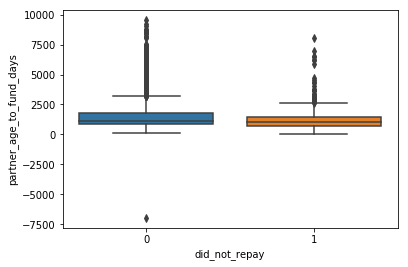

In [15]:
sns.boxplot(x='did_not_repay', y='partner_age_to_fund_days', data=df)

Split the Sales month1 £ and # into quartiles for use by ml algorithms later and give us an idea of numbers that are involved.

In [15]:
df['£_Sales_Perc25Bin'] = pd.qcut(df['£_sales_month_1'].values,
                     q=[0.001, .25, .5, .75, .99],
                     labels=[0, 25, 50, 99]) #, retbins=True

print(pd.qcut(df['£_sales_month_1'].values,
                     q=[0.001, .25, .5, .75, .995],
                     labels=[0, 25, 50, 99], retbins=True)[1])

df['#_Sales_Perc25Bin'] = pd.qcut(df['#_sales_month_1'].values,
                     q=[0.001, .25, .5, .75, .99],
                     labels=[0, 25, 50, 99]) #, retbins=True

print(pd.qcut(df['#_sales_month_1'].values,
                     q=[0.001, .25, .5, .75, .995],
                     labels=[0, 25, 50, 99], retbins=True)[1])

df['£_avgSale_Perc25Bin'] = pd.qcut(df['£_avgSale_month_1'].values,
                     q=[0.001, .25, .5, .75, .99],
                     labels=[0, 25, 50, 99]) #, retbins=True

print(pd.qcut(df['£_avgSale_month_1'].values,
                     q=[0.001, .25, .5, .75, .995],
                     labels=[0, 25, 50, 99], retbins=True)[1])

[     0.       4926.37     8726.      16741.42   174928.7092]
[   0.     60.    179.    449.   4589.32]
[   4.372248     22.71075878   46.2625438   142.36825117 1922.24222983]


In [16]:
df['£_Sales_Perc25Bin'] = df['£_Sales_Perc25Bin'].astype(float) # problems if trying to convert to int due to nan error issues.
df['#_Sales_Perc25Bin'] = df['#_Sales_Perc25Bin'].astype(float)
df['£_avgSale_Perc25Bin'] = df['£_avgSale_Perc25Bin'].astype(float)

Financial Stability features can be estimated from the volatility of the cash flows (£ amounts, #s and avg Sale) ie. how the amounts received vary around both the mean (standard deviation (std)) or the median (interquartile range (iqr))

In [17]:
df['£_sales_std_months_all'] = df.apply(lambda x: np.nanstd([x['£_sales_month_1'], x['£_sales_month_2'],
       x['£_sales_month_3'], x['£_sales_month_4'], x['£_sales_month_5'],
       x['£_sales_month_6'], x['£_sales_month_7'], x['£_sales_month_8'],
       x['£_sales_month_9'], x['£_sales_month_10'], x['£_sales_month_11'],
       x['£_sales_month_12'], x['£_sales_month_13'], x['£_sales_month_14'],
       x['£_sales_month_15'], x['£_sales_month_16'], x['£_sales_month_17'],
       x['£_sales_month_18'], x['£_sales_month_19'], x['£_sales_month_20'],
       x['£_sales_month_21'], x['£_sales_month_22'], x['£_sales_month_23'],
       x['£_sales_month_24']]), axis=1)

C:\Users\Richard\Miniconda3\envs\xgbDSv2\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [18]:
df['#_sales_std_months_all'] = df.apply(lambda x: np.nanstd([x['#_sales_month_1'], x['#_sales_month_2'],
       x['#_sales_month_3'], x['#_sales_month_4'], x['#_sales_month_5'],
       x['#_sales_month_6'], x['#_sales_month_7'], x['#_sales_month_8'],
       x['#_sales_month_9'], x['#_sales_month_10'], x['#_sales_month_11'],
       x['#_sales_month_12'], x['#_sales_month_13'], x['#_sales_month_14'],
       x['#_sales_month_15'], x['#_sales_month_16'], x['#_sales_month_17'],
       x['#_sales_month_18'], x['#_sales_month_19'], x['#_sales_month_20'],
       x['#_sales_month_21'], x['#_sales_month_22'], x['#_sales_month_23'],
       x['#_sales_month_24']]), axis=1)

In [19]:
df['£_avgSale_std_months_all'] = df.apply(lambda x: np.nanstd([x['£_avgSale_month_1'], x['£_avgSale_month_2'],
       x['£_avgSale_month_3'], x['£_avgSale_month_4'], x['£_avgSale_month_5'],
       x['£_avgSale_month_6'], x['£_avgSale_month_7'], x['£_avgSale_month_8'],
       x['£_avgSale_month_9'], x['£_avgSale_month_10'], x['£_avgSale_month_11'],
       x['£_avgSale_month_12'], x['£_avgSale_month_13'], x['£_avgSale_month_14'],
       x['£_avgSale_month_15'], x['£_avgSale_month_16'], x['£_avgSale_month_17'],
       x['£_avgSale_month_18'], x['£_avgSale_month_19'], x['£_avgSale_month_20'],
       x['£_avgSale_month_21'], x['£_avgSale_month_22'], x['£_avgSale_month_23'],
       x['£_avgSale_month_24']]), axis=1)

In [20]:
df['£_sales_iqr_months_all'] = df.apply(lambda x: np.nanpercentile([x['£_sales_month_1'], x['£_sales_month_2'],
       x['£_sales_month_3'], x['£_sales_month_4'], x['£_sales_month_5'],
       x['£_sales_month_6'], x['£_sales_month_7'], x['£_sales_month_8'],
       x['£_sales_month_9'], x['£_sales_month_10'], x['£_sales_month_11'],
       x['£_sales_month_12'], x['£_sales_month_13'], x['£_sales_month_14'],
       x['£_sales_month_15'], x['£_sales_month_16'], x['£_sales_month_17'],
       x['£_sales_month_18'], x['£_sales_month_19'], x['£_sales_month_20'],
       x['£_sales_month_21'], x['£_sales_month_22'], x['£_sales_month_23'],
       x['£_sales_month_24']], 75) - np.nanpercentile([x['£_sales_month_1'], x['£_sales_month_2'],
       x['£_sales_month_3'], x['£_sales_month_4'], x['£_sales_month_5'],
       x['£_sales_month_6'], x['£_sales_month_7'], x['£_sales_month_8'],
       x['£_sales_month_9'], x['£_sales_month_10'], x['£_sales_month_11'],
       x['£_sales_month_12'], x['£_sales_month_13'], x['£_sales_month_14'],
       x['£_sales_month_15'], x['£_sales_month_16'], x['£_sales_month_17'],
       x['£_sales_month_18'], x['£_sales_month_19'], x['£_sales_month_20'],
       x['£_sales_month_21'], x['£_sales_month_22'], x['£_sales_month_23'],
       x['£_sales_month_24']], 25), axis=1)

C:\Users\Richard\Miniconda3\envs\xgbDSv2\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [21]:
df['#_sales_iqr_months_all'] = df.apply(lambda x: np.nanpercentile([x['#_sales_month_1'], x['#_sales_month_2'],
       x['#_sales_month_3'], x['#_sales_month_4'], x['#_sales_month_5'],
       x['#_sales_month_6'], x['#_sales_month_7'], x['#_sales_month_8'],
       x['#_sales_month_9'], x['#_sales_month_10'], x['#_sales_month_11'],
       x['#_sales_month_12'], x['#_sales_month_13'], x['#_sales_month_14'],
       x['#_sales_month_15'], x['#_sales_month_16'], x['#_sales_month_17'],
       x['#_sales_month_18'], x['#_sales_month_19'], x['#_sales_month_20'],
       x['#_sales_month_21'], x['#_sales_month_22'], x['#_sales_month_23'],
       x['#_sales_month_24']], 75) - np.nanpercentile([x['#_sales_month_1'], x['#_sales_month_2'],
       x['#_sales_month_3'], x['#_sales_month_4'], x['#_sales_month_5'],
       x['#_sales_month_6'], x['#_sales_month_7'], x['#_sales_month_8'],
       x['#_sales_month_9'], x['#_sales_month_10'], x['#_sales_month_11'],
       x['#_sales_month_12'], x['#_sales_month_13'], x['#_sales_month_14'],
       x['#_sales_month_15'], x['#_sales_month_16'], x['#_sales_month_17'],
       x['#_sales_month_18'], x['#_sales_month_19'], x['#_sales_month_20'],
       x['#_sales_month_21'], x['#_sales_month_22'], x['#_sales_month_23'],
       x['#_sales_month_24']], 25), axis=1)

In [22]:
df['£_avgSale_iqr_months_all'] = df.apply(lambda x: np.nanpercentile([x['£_avgSale_month_1'], x['£_avgSale_month_2'],
       x['£_avgSale_month_3'], x['£_avgSale_month_4'], x['£_avgSale_month_5'],
       x['£_avgSale_month_6'], x['£_avgSale_month_7'], x['£_avgSale_month_8'],
       x['£_avgSale_month_9'], x['£_avgSale_month_10'], x['£_avgSale_month_11'],
       x['£_avgSale_month_12'], x['£_avgSale_month_13'], x['£_avgSale_month_14'],
       x['£_avgSale_month_15'], x['£_avgSale_month_16'], x['£_avgSale_month_17'],
       x['£_avgSale_month_18'], x['£_avgSale_month_19'], x['£_avgSale_month_20'],
       x['£_avgSale_month_21'], x['£_avgSale_month_22'], x['£_avgSale_month_23'],
       x['£_avgSale_month_24']], 75) - np.nanpercentile([x['£_avgSale_month_1'], x['£_avgSale_month_2'],
       x['£_avgSale_month_3'], x['£_avgSale_month_4'], x['£_avgSale_month_5'],
       x['£_avgSale_month_6'], x['£_avgSale_month_7'], x['£_avgSale_month_8'],
       x['£_avgSale_month_9'], x['£_avgSale_month_10'], x['£_avgSale_month_11'],
       x['£_avgSale_month_12'], x['£_avgSale_month_13'], x['£_avgSale_month_14'],
       x['£_avgSale_month_15'], x['£_avgSale_month_16'], x['£_avgSale_month_17'],
       x['£_avgSale_month_18'], x['£_avgSale_month_19'], x['£_avgSale_month_20'],
       x['£_avgSale_month_21'], x['£_avgSale_month_22'], x['£_avgSale_month_23'],
       x['£_avgSale_month_24']], 25), axis=1)

Let's also look at the volatility in revenues closer to funding ie. the last 6 months (or max within last 6 months)

In [23]:
df['£_sales_iqr_months_last6'] = df.apply(lambda x: np.nanpercentile([x['£_sales_month_1'], x['£_sales_month_2'],
       x['£_sales_month_3'], x['£_sales_month_4'], x['£_sales_month_5'],
       x['£_sales_month_6']], 75) - np.nanpercentile([x['£_sales_month_1'], x['£_sales_month_2'],
       x['£_sales_month_3'], x['£_sales_month_4'], x['£_sales_month_5'],
       x['£_sales_month_6']], 25), axis=1)

In [24]:
df['#_sales_iqr_months_last6'] = df.apply(lambda x: np.nanpercentile([x['#_sales_month_1'], x['#_sales_month_2'],
       x['#_sales_month_3'], x['#_sales_month_4'], x['#_sales_month_5'],
       x['#_sales_month_6']], 75) - np.nanpercentile([x['#_sales_month_1'], x['#_sales_month_2'],
       x['#_sales_month_3'], x['#_sales_month_4'], x['#_sales_month_5'],
       x['#_sales_month_6']], 25), axis=1)

In [25]:
df['£_avgSale_iqr_months_last6'] = df.apply(lambda x: np.nanpercentile([x['£_avgSale_month_1'], x['£_avgSale_month_2'],
       x['£_avgSale_month_3'], x['£_avgSale_month_4'], x['£_avgSale_month_5'],
       x['£_avgSale_month_6']], 75) - np.nanpercentile([x['£_avgSale_month_1'], x['£_avgSale_month_2'],
       x['£_avgSale_month_3'], x['£_avgSale_month_4'], x['£_avgSale_month_5'],
       x['£_avgSale_month_6']], 25), axis=1)

In [26]:
df['£_sales_std_months_all'] = df.apply(lambda x: np.nanstd([x['£_sales_month_1'], x['£_sales_month_2'],
       x['£_sales_month_3'], x['£_sales_month_4'], x['£_sales_month_5'],
       x['£_sales_month_6'], x['£_sales_month_7'], x['£_sales_month_8'],
       x['£_sales_month_9'], x['£_sales_month_10'], x['£_sales_month_11'],
       x['£_sales_month_12'], x['£_sales_month_13'], x['£_sales_month_14'],
       x['£_sales_month_15'], x['£_sales_month_16'], x['£_sales_month_17'],
       x['£_sales_month_18'], x['£_sales_month_19'], x['£_sales_month_20'],
       x['£_sales_month_21'], x['£_sales_month_22'], x['£_sales_month_23'],
       x['£_sales_month_24']]), axis=1)

A good proxy for the size of the business is the total revenue received (that we have knowledge of). 
Ideally we would like to calculate the amount of free cash (2x) that the business holds covering the BCA loan. The total cash received should be some kind of proxy for this.
Could also calculate the below at quearterly and half yearly intervals.

In [27]:
df['£_sales_sum_months_all'] = df.apply(lambda x: np.nansum([x['£_sales_month_1'], x['£_sales_month_2'],
       x['£_sales_month_3'], x['£_sales_month_4'], x['£_sales_month_5'],
       x['£_sales_month_6'], x['£_sales_month_7'], x['£_sales_month_8'],
       x['£_sales_month_9'], x['£_sales_month_10'], x['£_sales_month_11'],
       x['£_sales_month_12'], x['£_sales_month_13'], x['£_sales_month_14'],
       x['£_sales_month_15'], x['£_sales_month_16'], x['£_sales_month_17'],
       x['£_sales_month_18'], x['£_sales_month_19'], x['£_sales_month_20'],
       x['£_sales_month_21'], x['£_sales_month_22'], x['£_sales_month_23'],
       x['£_sales_month_24']]), axis=1)

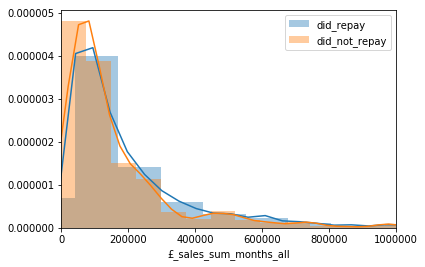

In [73]:
for x in defaults:
    subset = df[df['did_not_repay'] == x]
    sns.distplot(subset[~subset['£_sales_sum_months_all'].isnull()]['£_sales_sum_months_all'].astype(int))
    plt.xlim(0,1000000)
    plt.legend(labels=['did_repay','did_not_repay'])

Also the total actual numbers of sales is a good proxy for size and also market liquidity.

In [28]:
df['#_sales_sum_months_all'] = df.apply(lambda x: np.nansum([x['#_sales_month_1'], x['#_sales_month_2'],
       x['#_sales_month_3'], x['#_sales_month_4'], x['#_sales_month_5'],
       x['#_sales_month_6'], x['#_sales_month_7'], x['#_sales_month_8'],
       x['#_sales_month_9'], x['#_sales_month_10'], x['#_sales_month_11'],
       x['#_sales_month_12'], x['#_sales_month_13'], x['#_sales_month_14'],
       x['#_sales_month_15'], x['#_sales_month_16'], x['#_sales_month_17'],
       x['#_sales_month_18'], x['#_sales_month_19'], x['#_sales_month_20'],
       x['#_sales_month_21'], x['#_sales_month_22'], x['#_sales_month_23'],
       x['#_sales_month_24']]), axis=1)

Let's calcuate the avg # Sales per mth from the total sums calculated above.

In [29]:
df['£_sales_avgPerMth_months_all'] = df['£_sales_sum_months_all'] / df['#_sales_sum_months_all']

How many month's have we been given sales data on.

In [32]:
df['#_Count_sales_months'] = df.apply(lambda x: np.count_nonzero([x['£_sales_month_1'], x['£_sales_month_2'],
       x['£_sales_month_3'], x['£_sales_month_4'], x['£_sales_month_5'],
       x['£_sales_month_6'], x['£_sales_month_7'], x['£_sales_month_8'],
       x['£_sales_month_9'], x['£_sales_month_10'], x['£_sales_month_11'],
       x['£_sales_month_12'], x['£_sales_month_13'], x['£_sales_month_14'],
       x['£_sales_month_15'], x['£_sales_month_16'], x['£_sales_month_17'],
       x['£_sales_month_18'], x['£_sales_month_19'], x['£_sales_month_20'],
       x['£_sales_month_21'], x['£_sales_month_22'], x['£_sales_month_23'],
       x['£_sales_month_24']]), axis=1)

Let's add the quartile splits of theses total sales and # sales amounts.

In [33]:
df['£_sales_sum_Perc25Bin'] = pd.qcut(df['£_sales_sum_months_all'].values,
                     q=[0.001, .25, .5, .75, .99],
                     labels=[0, 25, 50, 99]) #, retbins=True

print(pd.qcut(df['£_sales_sum_months_all'].values,
                     q=[0.001, .25, .5, .75, .995],
                     labels=[0, 25, 50, 99], retbins=True)[1])

df['#_sales_sum_Perc25Bin'] = pd.qcut(df['#_sales_sum_months_all'].values,
                     q=[0.001, .25, .5, .75, .99],
                     labels=[0, 25, 50, 99]) #, retbins=True

print(pd.qcut(df['#_sales_sum_months_all'].values,
                     q=[0.001, .25, .5, .75, .995],
                     labels=[0, 25, 50, 99], retbins=True)[1])

[      0.           67607.45        125530.145       257035.4075
 3465397.46285001]
[    0.     851.5   2469.5   5870.75 67880.32]


In [34]:
df['£_sales_sum_Perc25Bin'] = df['£_sales_sum_Perc25Bin'].astype(float) # problems if trying to convert to int due to nan error issues.
df['#_sales_sum_Perc25Bin'] = df['#_sales_sum_Perc25Bin'].astype(float)

In [35]:
df.head()

,customer#,date_funded,£_sales_month_1,£_sales_month_2,£_sales_month_3,£_sales_month_4,£_sales_month_5,£_sales_month_6,£_sales_month_7,£_sales_month_8,...,£_avgSale_iqr_months_all,£_sales_iqr_months_last6,#_sales_iqr_months_last6,£_avgSale_iqr_months_last6,£_sales_sum_months_all,#_sales_sum_months_all,£_sales_avgPerMth_months_all,#_Count_sales_months,£_sales_sum_Perc25Bin,#_sales_sum_Perc25Bin
0,0,2016-09-12,10057.69,9700.72,7864.35,7536.20,6282.52,6407.90,6773.96,5057.86,...,1.393260,2551.6525,236.00,1.247191,163327.69,32807.0,4.978440,24,50.0,99.0
1,1,2017-11-13,7813.95,5019.91,9268.47,9076.38,6878.98,8079.04,10899.96,5303.31,...,6.948074,1714.3225,51.75,4.565070,165792.72,4621.0,35.878104,24,50.0,50.0
2,2,2017-05-09,18919.34,13519.00,13351.21,14313.37,13863.37,10624.31,17716.63,14834.26,...,8.122904,807.7125,72.75,6.151134,261475.99,6299.0,41.510714,24,99.0,99.0
3,3,2016-07-12,18303.56,13128.60,19862.03,15840.20,15833.94,9241.48,18495.11,13924.29,...,6.472707,3882.7850,155.75,6.431001,292702.32,11048.0,26.493693,24,99.0,99.0
4,4,2016-09-12,6959.29,7038.20,7222.07,7083.17,7236.45,6456.99,4503.40,6500.28,...,24.321045,208.3275,5.00,11.132407,63570.02,437.0,145.469153,24,0.0,0.0


For a proxy for growth we could look at the gross change in cumulatively summed sales
however let's be more creative and try to get the average 1month change in the 3 month rolling mean, the latter nicely smoothing any abrupt changes.

In [39]:
cols_Money = ['customer#', 'date_funded','did_not_repay',
       '£_sales_month_1', '£_sales_month_2',
       '£_sales_month_3', '£_sales_month_4', '£_sales_month_5',
       '£_sales_month_6', '£_sales_month_7', '£_sales_month_8',
       '£_sales_month_9', '£_sales_month_10', '£_sales_month_11',
       '£_sales_month_12', '£_sales_month_13', '£_sales_month_14',
       '£_sales_month_15', '£_sales_month_16', '£_sales_month_17',
       '£_sales_month_18', '£_sales_month_19', '£_sales_month_20',
       '£_sales_month_21', '£_sales_month_22', '£_sales_month_23',
       '£_sales_month_24']

df_Money = df[cols_Money]

In [40]:
df_Money_Melt = pd.melt(df_Money, id_vars=['customer#', 'date_funded','date_joined_partner', 'did_not_repay'], value_vars=['£_sales_month_1', '£_sales_month_2',
       '£_sales_month_3', '£_sales_month_4', '£_sales_month_5',
       '£_sales_month_6', '£_sales_month_7', '£_sales_month_8',
       '£_sales_month_9', '£_sales_month_10', '£_sales_month_11',
       '£_sales_month_12', '£_sales_month_13', '£_sales_month_14',
       '£_sales_month_15', '£_sales_month_16', '£_sales_month_17',
       '£_sales_month_18', '£_sales_month_19', '£_sales_month_20',
       '£_sales_month_21', '£_sales_month_22', '£_sales_month_23',
       '£_sales_month_24'], value_name="£_Sales")

C:\Users\Richard\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [41]:
df_Money_Melt['month'] = np.where(df_Money_Melt['variable'].str.len() == 15, df_Money_Melt['variable'].str[-1:], df_Money_Melt['variable'].str[-2:])
df_Money_Melt['month'] = df_Money_Melt['month'].astype(int)
df_Money_Melt['Sales_dateM'] = df_Money_Melt['date_funded'].values.astype('datetime64[M]')
df_Money_Melt['Sales_dateM2'] = df_Money_Melt.apply(lambda x: x['Sales_dateM'] - pd.DateOffset(months=x['month']), axis=1)

In [42]:
df_Money_Melt.sort_values(['customer#','Sales_dateM2'], inplace=True)

In [43]:
df_Money_Melt.set_index('Sales_dateM2', inplace=True)

In [44]:
df_Money_Melt['rolling3m'] = df_Money_Melt.groupby('customer#')['£_Sales'].rolling(3).mean().reset_index(level=0, drop=True)
df_Money_Melt['pct_change_avg_roll3m_1m'] = df_Money_Melt.groupby('customer#')['rolling3m'].pct_change(1)
#replace all inf with nans
df_Money_Melt.replace([np.inf, -np.inf], np.nan, inplace=True)

We can see from the scatter plot below that the defaulter's are much more centered around the lower growth levels. This in part is due to the smaller sample size of the default class however.

(-2, 6)

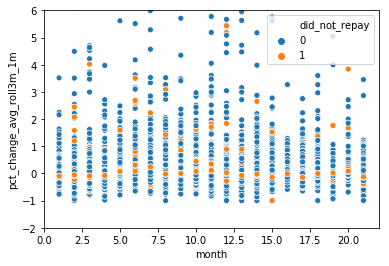

In [45]:
sns.scatterplot(y='pct_change_avg_roll3m_1m', x='month', hue='did_not_repay', data=df_Money_Melt)
plt.ylim(-2, 6)

In [46]:
df_Money_Melt_pct_change_roll3m_stacked = df_Money_Melt[['customer#','variable','pct_change_avg_roll3m_1m']]
df_Money_Melt_pct_change_roll3m_stacked.set_index(['customer#','variable'], inplace=True)

In [47]:
df_Money_Melt_pct_change_roll3m_unstacked = df_Money_Melt_pct_change_roll3m_stacked.unstack()
df_avg_roll_3m = df_Money_Melt_pct_change_roll3m_stacked.groupby('customer#')['pct_change_avg_roll3m_1m'].mean()

In [48]:
df_avg_roll_3m = pd.DataFrame(df_avg_roll_3m)
df_avg_roll_3m.reset_index(inplace=True)

Let's join this average percent change for the 3 month rolling mean back onto the main dataset

In [49]:
df = pd.merge(df, df_avg_roll_3m, how='left', on=['customer#'])

The below shows a clear (significance needs to be tested) difference in last 6 months iqr sales volatility for non-payers being higher ie. more unstable than payers.

In [75]:
df.pivot_table(values='£_sales_iqr_months_last6', index=['£_sales_sum_Perc25Bin'], columns=['did_not_repay'], aggfunc='median')

did_not_repay,0,1
£_sales_sum_Perc25Bin,,
0.0,1260.8775,1486.28500
25.0,1780.3375,2005.68625
50.0,2686.4450,3029.82000
99.0,6436.7650,7776.89875


In [50]:
df.date_funded_Yr.value_counts()

2017    2834
2018    1651
2016     515
Name: date_funded_Yr, dtype: int64

Deal with imbalanced target variable:

In [51]:
def undersample(train):
    count_class_0, count_class_1 = train.did_not_repay.value_counts()
    print(count_class_0, count_class_1)

    #Split train by classes:
    train_class_0 = train[train['did_not_repay'] == 0]
    train_class_1 = train[train['did_not_repay'] == 1]

    train_class_0_under = train_class_0.sample(count_class_1)
    train_under = pd.concat([train_class_1, train_class_0_under], axis=0)

    print('Random undersampling, new counts in new train_under set:')
    print(train_under.did_not_repay.value_counts())
    
    return train_under

In [52]:
def oversample(train):
    count_class_0, count_class_1 = train.did_not_repay.value_counts()
    print(count_class_0, count_class_1)

    #Split train by classes:
    train_class_0 = train[train['did_not_repay'] == 0]
    train_class_1 = train[train['did_not_repay'] == 1]

    train_class_1_over = train_class_1.sample(count_class_0, replace=True)
    train_over = pd.concat([train_class_0, train_class_1_over], axis=0)

    print('Random oversampling, new counts in new train_over set:')
    print(train_over.did_not_repay.value_counts())
    
    return train_over

Let's choose a future out of time split and use a iterate through different imbalanced class methods.
This ensures no leakage of current (test) economic trends into training set.

In [53]:
def train_test_year_split(data, split_date='2018-01-01', imbalance_method=None, impute=None, cols=None):
    if cols is not None:
        model_data = data[cols]

    #split by year
    train = model_data.loc[model_data['date_funded'] < split_date]
    test = model_data.loc[model_data['date_funded'] >= split_date]
    
    #print("Train split: " + train.date_funded_Yr.value_counts())
    #print("Test split: " + test.date_funded_Yr.value_counts())
    
    if imbalance_method == 'under':
        train = undersample(train)
    elif imbalance_method == 'over':
        train = oversample(train)
    
    numerical_features = ['£_sales_month_1', '£_sales_month_2',
       '£_sales_month_3', '£_sales_month_4', '£_sales_month_5',
       '£_sales_month_6', '£_sales_month_7', '£_sales_month_8',
       '£_sales_month_9', '£_sales_month_10', '£_sales_month_11',
       '£_sales_month_12', '£_sales_month_13', '£_sales_month_14',
       '£_sales_month_15', '£_sales_month_16', '£_sales_month_17',
       '£_sales_month_18', '£_sales_month_19', '£_sales_month_20',
       '£_sales_month_21', '£_sales_month_22', '£_sales_month_23',
       '£_sales_month_24', '#_sales_month_1', '#_sales_month_2',
       '#_sales_month_3', '#_sales_month_4', '#_sales_month_5',
       '#_sales_month_6', '#_sales_month_7', '#_sales_month_8',
       '#_sales_month_9', '#_sales_month_10', '#_sales_month_11',
       '#_sales_month_12', '#_sales_month_13', '#_sales_month_14',
       '#_sales_month_15', '#_sales_month_16', '#_sales_month_17',
       '#_sales_month_18', '#_sales_month_19', '#_sales_month_20',
       '#_sales_month_21', '#_sales_month_22', '#_sales_month_23',
       '#_sales_month_24', 'did_not_repay',
       'date_funded_Yr', 'date_joined_partner_Yr', 'partner_age_to_fund',
       'partner_age_to_fund_days', 'partner_age_to_fund_months',
       'partner_age_to_fund_years', '£_Sales_Perc25Bin', '£_avgSale_month_1',
       '£_avgSale_month_2', '£_avgSale_month_3', '£_avgSale_month_4',
       '£_avgSale_month_5', '£_avgSale_month_6', '£_avgSale_month_7',
       '£_avgSale_month_8', '£_avgSale_month_9', '£_avgSale_month_10',
       '£_avgSale_month_11', '£_avgSale_month_12', '£_avgSale_month_13',
       '£_avgSale_month_14', '£_avgSale_month_15', '£_avgSale_month_16',
       '£_avgSale_month_17', '£_avgSale_month_18', '£_avgSale_month_19',
       '£_avgSale_month_20', '£_avgSale_month_21', '£_avgSale_month_22',
       '£_avgSale_month_23', '£_avgSale_month_24',
       '£_Sales_Perc25Bin', '#_Sales_Perc25Bin', '£_avgSale_Perc25Bin',
       '£_sales_std_months_all','#_sales_std_months_all', '£_avgSale_std_months_all',
       '£_sales_iqr_months_all','#_sales_iqr_months_all', '£_avgSale_iqr_months_all',
       '£_sales_iqr_months_last6', '#_sales_iqr_months_last6', '£_avgSale_iqr_months_last6',
       '£_sales_sum_months_all', '#_sales_sum_months_all',
       '£_sales_avgPerMth_months_all', '#_Count_sales_months','£_sales_sum_Perc25Bin','#_sales_sum_Perc25Bin']
    
    #numerical_features = train.select_dtypes(exclude = ["object"]).columns
    
    #print(type(numerical_features))
    #numerical_features.remove('date_funded')
    #numerical_features.remove('date_joined_partner')
    
    if impute == 'median':
        for col in numerical_features:
            train[col].fillna(train[col].median(), inplace=True)
            test[col].fillna(test[col].median(), inplace=True)
    elif impute == -1:
        for col in numerical_features:
            train[col].fillna(-1, inplace=True)
            test[col].fillna(-1, inplace=True)
            
        
    total = train.isnull().sum().sort_values(ascending=False)
    percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.head(10)
    
    total = test.isnull().sum().sort_values(ascending=False)
    percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data.head(10)
    
    X_train = train.drop(['did_not_repay','customer#','date_funded','date_joined_partner','partner_age_to_fund'], axis=1)
    y_train = train['did_not_repay']
    
    X_test = test.drop(['did_not_repay','customer#','date_funded','date_joined_partner','partner_age_to_fund'], axis=1)
    y_test = test['did_not_repay']
    
    print("y_train shape, defualt count:")
    print(y_train.shape, y_train.sum())
    
    print("y_test shape, defualt count:")
    print(y_test.shape, y_test.sum())
    
    print("X_train columns:")
    print(X_train.columns)
    
    return X_train, y_train, X_test, y_test

In [54]:
all_cols =['customer#'
,'date_funded'
,'£_sales_month_1'
,'£_sales_month_2'
,'£_sales_month_3'
,'£_sales_month_4'
,'£_sales_month_5'
,'£_sales_month_6'
,'£_sales_month_7'
,'£_sales_month_8'
,'£_sales_month_9'
,'£_sales_month_10'
,'£_sales_month_11'
,'£_sales_month_12'
,'£_sales_month_13'
,'£_sales_month_14'
,'£_sales_month_15'
,'£_sales_month_16'
,'£_sales_month_17'
,'£_sales_month_18'
,'£_sales_month_19'
,'£_sales_month_20'
,'£_sales_month_21'
,'£_sales_month_22'
,'£_sales_month_23'
,'£_sales_month_24'
,'#_sales_month_1'
,'#_sales_month_2'
,'#_sales_month_3'
,'#_sales_month_4'
,'#_sales_month_5'
,'#_sales_month_6'
,'#_sales_month_7'
,'#_sales_month_8'
,'#_sales_month_9'
,'#_sales_month_10'
,'#_sales_month_11'
,'#_sales_month_12'
,'#_sales_month_13'
,'#_sales_month_14'
,'#_sales_month_15'
,'#_sales_month_16'
,'#_sales_month_17'
,'#_sales_month_18'
,'#_sales_month_19'
,'#_sales_month_20'
,'#_sales_month_21'
,'#_sales_month_22'
,'#_sales_month_23'
,'#_sales_month_24'
,'date_joined_partner'
,'did_not_repay'
,'£_avgSale_month_1'
,'£_avgSale_month_2'
,'£_avgSale_month_3'
,'£_avgSale_month_4'
,'£_avgSale_month_5'
,'£_avgSale_month_6'
,'£_avgSale_month_7'
,'£_avgSale_month_8'
,'£_avgSale_month_9'
,'£_avgSale_month_10'
,'£_avgSale_month_11'
,'£_avgSale_month_12'
,'£_avgSale_month_13'
,'£_avgSale_month_14'
,'£_avgSale_month_15'
,'£_avgSale_month_16'
,'£_avgSale_month_17'
,'£_avgSale_month_18'
,'£_avgSale_month_19'
,'£_avgSale_month_20'
,'£_avgSale_month_21'
,'£_avgSale_month_22'
,'£_avgSale_month_23'
,'£_avgSale_month_24'
,'date_funded_Yr'
,'date_joined_partner_Yr'
,'date_funded_Mth'
,'date_joined_partner_Mth'
,'partner_age_to_fund'
,'partner_age_to_fund_days'
,'partner_age_to_fund_months'
,'partner_age_to_fund_years'
,'£_Sales_Perc25Bin'
,'#_Sales_Perc25Bin'
,'£_avgSale_Perc25Bin'
,'£_sales_std_months_all'
,'#_sales_std_months_all'
,'£_avgSale_std_months_all'
,'£_sales_iqr_months_all'
,'#_sales_iqr_months_all'
,'£_avgSale_iqr_months_all'
,'£_sales_iqr_months_last6'
,'#_sales_iqr_months_last6'
,'£_avgSale_iqr_months_last6'
,'£_sales_sum_months_all'
,'#_sales_sum_months_all'
,'£_sales_avgPerMth_months_all'
,'#_Count_sales_months'
,'£_sales_sum_Perc25Bin'
,'#_sales_sum_Perc25Bin'
,'pct_change_avg_roll3m_1m']

In [55]:
model_Cols = ['customer#'
,'date_funded'
,'£_sales_month_1'
,'£_sales_month_2'
,'£_sales_month_3'
,'£_sales_month_4'
,'£_sales_month_5'
,'£_sales_month_6'
,'£_sales_month_7'
,'£_sales_month_8'
,'£_sales_month_9'
,'£_sales_month_10'
,'£_sales_month_11'
,'£_sales_month_12'
,'£_sales_month_13'
,'£_sales_month_14'
,'£_sales_month_15'
,'£_sales_month_16'
,'£_sales_month_17'
,'£_sales_month_18'
,'£_sales_month_19'
,'£_sales_month_20'
,'£_sales_month_21'
,'£_sales_month_22'
,'£_sales_month_23'
,'£_sales_month_24'
,'#_sales_month_1'
,'#_sales_month_2'
,'#_sales_month_3'
,'#_sales_month_4'
,'#_sales_month_5'
,'#_sales_month_6'
,'#_sales_month_7'
,'#_sales_month_8'
,'#_sales_month_9'
,'#_sales_month_10'
,'#_sales_month_11'
,'#_sales_month_12'
,'#_sales_month_13'
,'#_sales_month_14'
,'#_sales_month_15'
,'#_sales_month_16'
,'#_sales_month_17'
,'#_sales_month_18'
,'#_sales_month_19'
,'#_sales_month_20'
,'#_sales_month_21'
,'#_sales_month_22'
,'#_sales_month_23'
,'#_sales_month_24'
,'date_joined_partner'
,'did_not_repay'
,'£_avgSale_month_1'
,'£_avgSale_month_2'
,'£_avgSale_month_3'
,'£_avgSale_month_4'
,'£_avgSale_month_5'
,'£_avgSale_month_6'
,'£_avgSale_month_7'
,'£_avgSale_month_8'
,'£_avgSale_month_9'
,'£_avgSale_month_10'
,'£_avgSale_month_11'
,'£_avgSale_month_12'
,'£_avgSale_month_13'
,'£_avgSale_month_14'
,'£_avgSale_month_15'
,'£_avgSale_month_16'
,'£_avgSale_month_17'
,'£_avgSale_month_18'
,'£_avgSale_month_19'
,'£_avgSale_month_20'
,'£_avgSale_month_21'
,'£_avgSale_month_22'
,'£_avgSale_month_23'
,'£_avgSale_month_24'
,'date_funded_Yr'
,'date_joined_partner_Yr'
,'date_funded_Mth'
,'date_joined_partner_Mth'
,'partner_age_to_fund'
,'partner_age_to_fund_days'
,'partner_age_to_fund_months'
,'partner_age_to_fund_years'
,'£_Sales_Perc25Bin'
,'#_Sales_Perc25Bin'
,'£_avgSale_Perc25Bin'
,'£_sales_std_months_all'
,'#_sales_std_months_all'
,'£_avgSale_std_months_all'
,'£_sales_iqr_months_all'
,'#_sales_iqr_months_all'
,'£_avgSale_iqr_months_all'
,'£_sales_iqr_months_last6'
,'#_sales_iqr_months_last6'
,'£_avgSale_iqr_months_last6'
,'£_sales_sum_months_all'
,'#_sales_sum_months_all'
,'£_sales_avgPerMth_months_all'
,'#_Count_sales_months'
,'£_sales_sum_Perc25Bin'
,'#_sales_sum_Perc25Bin']

Undersampling found to get the best lift in f1 score.
However this invariably leads to loss of information from the larger class data set.
This strategy for addressing the imbalanced data set probably needs to be improved on.
Have removed column 'pct_change_avg_roll3m_1m' found it to negatively impact models.
Need to do more thorough feature selection by iterating through all combinations of above model.
nan imputation = 'median' for non xgboost models.
no impuation for xgboost.

In [60]:
X_train, y_train, X_test, y_test = train_test_year_split(df, split_date='2018-01-01', imbalance_method='under', impute='median', cols=model_Cols)

2977 372
Random undersampling, new counts in new train_under set:
1    372
0    372
Name: did_not_repay, dtype: int64


C:\Users\Richard\AppData\Roaming\Python\Python36\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


y_train shape, defualt count:
(744,) 372
y_test shape, defualt count:
(1651,) 203
X_train columns:
Index(['£_sales_month_1', '£_sales_month_2', '£_sales_month_3',
       '£_sales_month_4', '£_sales_month_5', '£_sales_month_6',
       '£_sales_month_7', '£_sales_month_8', '£_sales_month_9',
       '£_sales_month_10', '£_sales_month_11', '£_sales_month_12',
       '£_sales_month_13', '£_sales_month_14', '£_sales_month_15',
       '£_sales_month_16', '£_sales_month_17', '£_sales_month_18',
       '£_sales_month_19', '£_sales_month_20', '£_sales_month_21',
       '£_sales_month_22', '£_sales_month_23', '£_sales_month_24',
       '#_sales_month_1', '#_sales_month_2', '#_sales_month_3',
       '#_sales_month_4', '#_sales_month_5', '#_sales_month_6',
       '#_sales_month_7', '#_sales_month_8', '#_sales_month_9',
       '#_sales_month_10', '#_sales_month_11', '#_sales_month_12',
       '#_sales_month_13', '#_sales_month_14', '#_sales_month_15',
       '#_sales_month_16', '#_sales_month_17', '

In [63]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=7, random_state=0)
tree.fit(X_train, y_train)
print("train: " + str(tree.score(X_train, y_train)))
print("test: " + str(tree.score(X_test, y_test)))

train: 0.782258064516129
test: 0.47546941247728647


In [64]:
y_true = y_test

In [65]:
y_pred = tree.predict(X_test)

print(classification_report(y_true, y_pred))         

              precision    recall  f1-score   support

           0       0.88      0.47      0.61      1448
           1       0.12      0.53      0.20       203

   micro avg       0.48      0.48      0.48      1651
   macro avg       0.50      0.50      0.40      1651
weighted avg       0.78      0.48      0.56      1651



We can see from the feature importance chart below that many engineered features proxing for stability, size and growth rank highly in a basic intial decision tree.

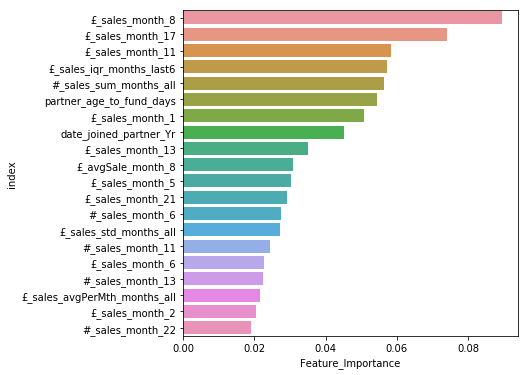

In [66]:
FeatImp = pd.DataFrame(tree.feature_importances_,index= X_train.columns,columns=['Feature_Importance'])
FeatImp.sort_values('Feature_Importance',ascending=False,inplace=True)

plt.figure(figsize=(6,6))
sns.barplot(x='Feature_Importance', y='index' , data=FeatImp.reset_index().head(20))
plt.show()

In [67]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

classifiers = {
    "Dummy"        : DummyClassifier(strategy='uniform', random_state=2),
    "KNN(3)"       : KNeighborsClassifier(3), 
    "RBF SVM"      : SVC(gamma=2, C=1), 
    "Decision Tree": DecisionTreeClassifier(max_depth=7), 
    "Random Forest": RandomForestClassifier(max_depth=7, n_estimators=1000, max_features=4), 
    "Neural Net"   : MLPClassifier(alpha=1), 
    "AdaBoost"     : AdaBoostClassifier(),
    "Naive Bayes"  : GaussianNB(), 
    "QDA"          : QuadraticDiscriminantAnalysis(),
    "Linear SVC"   : LinearSVC(),
    "Linear SVM"   : SVC(kernel="linear"), 
    "Gaussian Proc": GaussianProcessClassifier(1.0 * RBF(1.0)),
}

In [68]:
from time import time
nfast = 10      # Don't run the very slow ones
head = list(classifiers.items())[:nfast]

for name, classifier in head:
    start = time()
    classifier.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    score = classifier.score(X_test, y_test)
    score_time = time()-start
    print("{:<15}| score = {:.3f} | time = {:,.3f}s/{:,.3f}s".format(name, score, train_time, score_time))

Dummy          | score = 0.501 | time = 0.000s/0.000s
KNN(3)         | score = 0.519 | time = 0.002s/0.057s
RBF SVM        | score = 0.123 | time = 0.064s/0.141s
Decision Tree  | score = 0.478 | time = 0.017s/0.001s
Random Forest  | score = 0.516 | time = 0.852s/0.127s
Neural Net     | score = 0.392 | time = 0.184s/0.003s
AdaBoost       | score = 0.514 | time = 0.188s/0.011s
Naive Bayes    | score = 0.285 | time = 0.001s/0.004s
QDA            | score = 0.459 | time = 0.004s/0.005s
Linear SVC     | score = 0.294 | time = 0.139s/0.001s


C:\Users\Richard\Miniconda3\envs\xgbDSv2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [69]:
from time import time
nfast = 10      # Don't run the very slow ones
head = list(classifiers.items())[:nfast]

for name, classifier in head:
    start = time()
    classifier.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    score = classifier.score(X_test, y_test)
    score_time = time()-start
    y_pred = classifier.predict(X_test)
    print(name)
    print(classification_report(y_true, y_pred))

Dummy
              precision    recall  f1-score   support

           0       0.88      0.50      0.64      1448
           1       0.12      0.51      0.20       203

   micro avg       0.50      0.50      0.50      1651
   macro avg       0.50      0.50      0.42      1651
weighted avg       0.79      0.50      0.58      1651

KNN(3)
              precision    recall  f1-score   support

           0       0.88      0.52      0.66      1448
           1       0.12      0.48      0.20       203

   micro avg       0.52      0.52      0.52      1651
   macro avg       0.50      0.50      0.43      1651
weighted avg       0.79      0.52      0.60      1651

RBF SVM
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1448
           1       0.12      1.00      0.22       203

   micro avg       0.12      0.12      0.12      1651
   macro avg       0.06      0.50      0.11      1651
weighted avg       0.02      0.12      0.03      1651

C:\Users\Richard\Miniconda3\envs\xgbDSv2\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Richard\Miniconda3\envs\xgbDSv2\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Richard\Miniconda3\envs\xgbDSv2\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Random Forest
              precision    recall  f1-score   support

           0       0.90      0.53      0.66      1448
           1       0.14      0.56      0.23       203

   micro avg       0.53      0.53      0.53      1651
   macro avg       0.52      0.54      0.45      1651
weighted avg       0.80      0.53      0.61      1651

Neural Net
              precision    recall  f1-score   support

           0       0.89      0.26      0.40      1448
           1       0.13      0.78      0.22       203

   micro avg       0.32      0.32      0.32      1651
   macro avg       0.51      0.52      0.31      1651
weighted avg       0.80      0.32      0.38      1651

AdaBoost
              precision    recall  f1-score   support

           0       0.88      0.52      0.65      1448
           1       0.12      0.49      0.20       203

   micro avg       0.51      0.51      0.51      1651
   macro avg       0.50      0.50      0.43      1651
weighted avg       0.79      0.51      0

C:\Users\Richard\Miniconda3\envs\xgbDSv2\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Testing other methods of dealing with imbalanced target variables data sets:
None yield better reults than simple undersampling. This should be investigated further however.

In [448]:
from imblearn.under_sampling import ClusterCentroids

cc = ClusterCentroids(ratio={0: 10})
X_train, y_train = cc.fit_sample(X_train, y_train)

In [449]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_train, y_train = smote.fit_sample(X_train, y_train)

In [450]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
X_train, y_train = smt.fit_sample(X_train, y_train)

In [451]:
print(y_train.shape)
print(np.sum(y_train))

(740,)
370


Trying xgboost below now to try and beat best contenders (untuned above):

In [452]:
xgb = XGBClassifier(
    max_depth=4,
    learning_rate=0.001,
    n_estimators=500,
    silent=True,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=-1,
    nthread=-1,
    gamma=0,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    reg_alpha=0.1,
    reg_lambda=1,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=None,
    missing=None,
)

In [456]:
xgb.fit(X_train, y_train, eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.001, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=-1, objective='binary:logistic', random_state=0,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Need to enter as a matri (with no col headers as xgb converts trained df as such)
if using under or over above then use raw i.e xgb.predict(X_test)
if using imblearn use xgb.predict(X_test.values)

In [457]:
pred = xgb.predict(X_test)

In [484]:
print("\nModel Report")
print(classification_report(y_test, pred))


Model Report
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1448
           1       0.18      0.43      0.25       203

   micro avg       0.69      0.69      0.69      1651
   macro avg       0.54      0.58      0.53      1651
weighted avg       0.81      0.69      0.74      1651



Using oversampling, f1 =0.07 hence use undersampling.

In [459]:
FeatImp = pd.DataFrame(xgb.feature_importances_,index= X_train.columns,columns=['Feature_Importance'])
FeatImp.sort_values('Feature_Importance',ascending=False,inplace=True)

We see the size of the business and a longer past relationship with the partner are very important in predicting default behaviour.

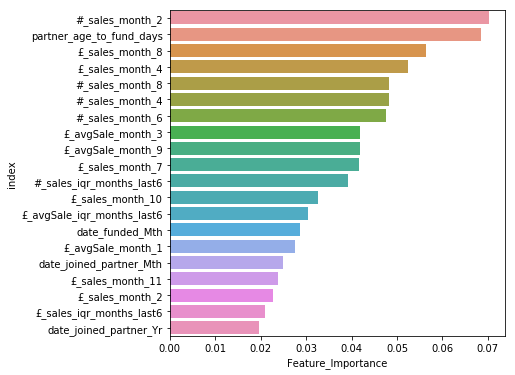

In [460]:
plt.figure(figsize=(6,6))
sns.barplot(x='Feature_Importance', y='index' , data=FeatImp.reset_index().head(20))
plt.show()

Let's go with the xgboost model as it's performing the best.
If more time I would tune both the hyperparameters properly and the features used in the model.

In [467]:
print(np.sum(pred))
print(len(pred))

484
1651


Let's check how many customers in our predicted data set we accept for a BCA loan:

In [462]:
1 - (np.sum(pred)/len(pred))

This just keeps us within the business constraints.

If we find we don't hit the 70% constaint then we can obtine our predictions by probability of defaulting rather than binary classification.
From here then disapprove the top 30% and keep the lower 70%.

In [389]:
pred_prob = xgb.predict_proba(X_test)

We can see from the xgboost model classification report above that the model performance isn't very good.
Precision is only 18% meaning we're misclassifying 82% of the time.
Recal is only 43% meaning we're failing to detect 57% of all true positive defaulters.
So unfortunately seeing as we are approving the 70% required. It looks like 82%*484=396 are actually false positives and hence will lose us money in this test set=

In [470]:
(1-0.18)*484*50

19844.000000000004

So out of the 600 credit decisions liberis are making per month this model will potentially lose Liberis:

In [473]:
(1-0.18)*484*50*(600/1651)

7211.629315566324

Of course the above loss will be offset by the amounts of the saved defaulted BCA loan amounts and possible decrease in CRA fees, data for which would potentially bring more performance uplift to this model.

## Business summary and Ideas for future model iterations:
Use a proper out of time cross validation and testing model tuning strategy.
Some kind of basic ensemble could also help results together with some PCA to reduce multicololinearity caused by some features. Ensembling between probably linear (logistic) and tree based models (uncorrelated so might help each other in deficient areas).
The issue of how to deal with nulls and fill in cashflows that havn't been provided. Obviously the lack of data is meaningful in itself and can be added as a binary feature.
Some kind of cash flow prediction based on clusters of similar performing customers (same funding half year, financial year etc.) used to help fill in missing cashflow vales could also help, together with utilising price indexes to remove some of the seasonality in these time series.
This data also has the potential for doing well in a deep Neural Network as shown by the promising result in the multi-model test above.
The commercial effectiveness of a model can be monitored as we've done here and further using a robust A/B testing framework to determine if differences observed are truely significant for the principle metric of choice (eg. f1 score or recall). Also one can back test by training the model on past data and seeing how it would have performed in comparison to the current credit scoring model. One of the other models trained above could be use for this.
Partial dependency plots would be useful in understanding how the model is working in respect to trends with key variables.
The black box nature of gradient boosting models would however have to be addressed. Unseen bias can easily introduced and needs to be monitored from both a ethical and regulatory standpoint. Luckily model explainability techniques such as LIME and SHAP are showing good results and meeting regulartory requirement in the credit decisioning field.